Notebook for doing my data analysis for my Thesis on E. Coli mutation data from Experimental Evolution experiments sourced from AleDb

# Set up

Running packages

In [1]:
pip install biopython

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [2]:
import glob
import pandas as pd
import os
import google.colab
import numpy as np
import matplotlib.pyplot as plt
from Bio.SubsMat import MatrixInfo
import scipy
from sklearn import decomposition
import seaborn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Uploading data from local to google collab server

In [3]:
from google.colab import files
uploaded = files.upload()

Saving 42C.csv.xlsx to 42C.csv.xlsx
Saving 42CTenaillonAra.csv.xlsx to 42CTenaillonAra.csv.xlsx
Saving Auxotrophic strains hisD gltA.csv.xlsx to Auxotrophic strains hisD gltA.csv.xlsx
Saving Auxotrophic strains hisD gltB.csv.xlsx to Auxotrophic strains hisD gltB.csv.xlsx
Saving Auxotrophic strains hisD pyrC.csv.xlsx to Auxotrophic strains hisD pyrC.csv.xlsx
Saving C13.csv.xlsx to C13.csv.xlsx
Saving C321.csv.xlsx to C321.csv.xlsx
Saving C321deltaA.csv.xlsx to C321deltaA.csv.xlsx
Saving C321deltaAearlyfix.csv.xlsx to C321deltaAearlyfix.csv.xlsx
Saving Central carbon knockout glucose evolution.csv.xlsx to Central carbon knockout glucose evolution.csv.xlsx
Saving Central carbon knockout gnd.csv.xlsx to Central carbon knockout gnd.csv.xlsx
Saving Central carbon knockout pgi.csv.xlsx to Central carbon knockout pgi.csv.xlsx
Saving Central carbon knockout PTS.csv.xlsx to Central carbon knockout PTS.csv.xlsx
Saving Central carbon knockout sdh.csv.xlsx to Central carbon knockout sdh.csv.xlsx
Sa

# Making Dataframes

Collecting data for DataFrame from converted files on desktop

In [0]:
df= pd.DataFrame()

In [0]:
experimentid = 1
for file in uploaded.keys():
    data = pd.read_excel(file, "Sheet1", header =4).assign(ExperimentID = experimentid)
    df = df.append(data, ignore_index=True)
    experimentid +=1


In [6]:
df

,CHROM,Start POS,End POS,TYPE,REF,ALT,GEN,∆AA,POP,CLON,TIME,FREQ,COM,ExperimentID
0,NC_000913,36231,36232.0,SNP,T,C,NaN,NaN,8,1,131,1.0,intergenic (‑69/+40),1
1,NC_000913,107553,107554.0,DEL,NaN,NaN,NaN,NaN,3,1,161,1.0,intergenic (+79/‑152),1
2,NC_000913,147727,147739.0,DEL,NaN,NaN,yadD,NaN,9,1,153,1.0,coding (760‑771/903 nt),1
3,NC_000913,149214,149215.0,SNP,C,T,panB,A130T,2,1,120,1.0,A130T (GCC→ACC),1
4,NC_000913,162973,162974.0,SNP,G,A,hrpB,C290Y,6,1,135,1.0,C290Y (TGT→TAT),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85016,NC_007779,4547860,4547861.0,INS,NaN,TCCCTCAGTTCTACAGCGGCTCTG,fimA,NaN,8,2,2000,1.0,coding (66/549 nt),54
85017,NC_007779,4626165,4626166.0,SNP,C,G,deoD,C201W,21,1,2000,1.0,C201W (TGC→TGG),54
85018,NC_007779,4639891,4639892.0,SNP,A,G,robA,S34P,20,1,2000,1.0,S34P (TCC→CCC),54
85019,NC_007779,4639891,4639892.0,SNP,A,G,robA,S34P,21,2,2000,1.0,S34P (TCC→CCC),54


In [0]:
# df.dtypes

Check types of mutations to look for new types that need to be added to the conversion script.

In [0]:
# dftest = df[df["TYPE"] == "CON"]
# print(dftest)

In [0]:
# df.groupby("TYPE").count()

Checking Chrom for different versions

In [10]:
df.groupby("CHROM").count()

,Start POS,End POS,TYPE,REF,ALT,GEN,∆AA,POP,CLON,TIME,FREQ,COM,ExperimentID
CHROM,,,,,,,,,,,,,
CP009273,862,862,862,633,833,384,281,862,862,862,862,862,862
NC_000913,76085,76085,76085,61737,67190,65503,56343,76085,76085,76085,76085,73054,76085
NC_007779,555,555,555,315,349,482,257,555,555,555,555,417,555
REL606,7519,7504,7519,3896,6081,6006,3338,7519,7519,7519,7519,7177,7519


Adding column to experiments for grouping them on severity of condition: 1 is severe, 2 is mild

In [0]:
condition = [2,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,1,2,2,1,1,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1]
df["Severity"] = ""
for i,row in df.iterrows():
  df.at[i, "Severity"] = condition[(df.iloc[i]["ExperimentID"])-1]

# Some basic visualizations

Distribution of mutations for all experiments, do not need title.

SNP     66566
DEL     10550
INS      7246
MNV       488
AMP2      127
AMP3       24
REPL       15
INV         3
AMP5        1
AMP4        1
Name: TYPE, dtype: int64


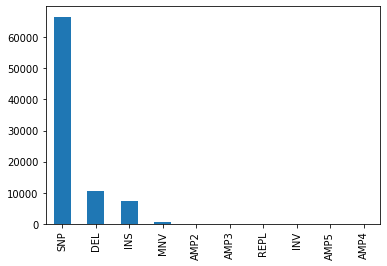

In [12]:
df["TYPE"].value_counts().plot(kind = 'bar')
print(df["TYPE"].value_counts())

For our analysis we are going to group all the Amplifications together

In [0]:
df = df.replace(to_replace= "AMP2", value = "AMP")
df = df.replace(to_replace= "AMP3", value = "AMP")
df = df.replace(to_replace= "AMP4", value = "AMP")
df = df.replace(to_replace= "AMP5", value = "AMP")

We now remove CON and INV since there are so few they do not show up (15 and 3 respectively)

In [14]:
df = df[df.TYPE != "CON"]
df = df.reset_index(drop=True)
df = df[df.TYPE != "INV"]
df = df.reset_index(drop=True)
df = df[df.TYPE != "REPL"]
df = df.reset_index(drop=True)
print(df["TYPE"].unique())

['SNP' 'DEL' 'INS' 'MNV' 'AMP']


In [15]:
total = df["TYPE"].value_counts().rename_axis('unique_values').reset_index(name='counts')
total_valu =total['counts'].sum()
total["Rel_Dist"] = ""
for i,row in total.iterrows():
  total.at[i, "Rel_Dist"] = total.loc[i]["counts"] / total_valu
total

,unique_values,counts,Rel_Dist
0,SNP,66566,0.783102
1,DEL,10550,0.124113
2,INS,7246,0.0852441
3,MNV,488,0.00574097
4,AMP,153,0.00179994


[66566, 10550, 7246, 488, 153]


Text(0, 0.5, 'Frequency')

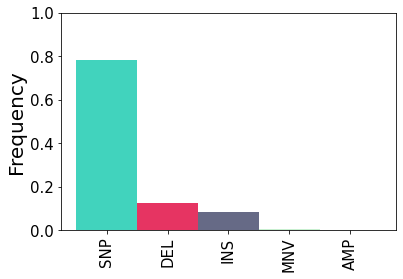

In [16]:
total = df["TYPE"].value_counts().rename_axis('unique_values').reset_index(name='counts')
total_valu =total['counts'].sum()
# Make some labels.
labels = []
total["Rel_Dist"] = ""
for i,row in total.iterrows():
  total.at[i, "Rel_Dist"] = total.loc[i]["counts"] / total_valu
  labels.append(total.loc[i]["counts"])
total.set_index("unique_values",drop=False,inplace=True)
print(labels)
colors = {"SNP": '#41D3BD', "DEL": '#E63462', "INS": '#666A86', "MNV": '#C7EFCF', "AMP": '#EEF5DB'}
types = list(colors.keys())
ax = total['Rel_Dist'].plot(kind='bar', width = 1.0, x = 'unique_values', y = 'Rel_Dist', color=[colors[i] for i in total['unique_values']])
# handles = [plt.Rectangle((0,0),1,1, color=colors[type]) for type in types]
# plt.legend(handles, types, fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel("")
ax.set_ylim(0,1)
ax.set_ylabel("Frequency", fontsize = 20)

We can check this distribution for every experiment as well.

In [0]:
Experiment_dataframes_all = []
for experiment in df["ExperimentID"].unique():
  Experiment_dataframes_all.append(df[df["ExperimentID"] ==experiment])
pca_mutation_type_df = pd.DataFrame(columns = ["SNP", "DEL", "INS", "MNV", "AMP"])

In [18]:
pca_mutation_type_df

,SNP,DEL,INS,MNV,AMP


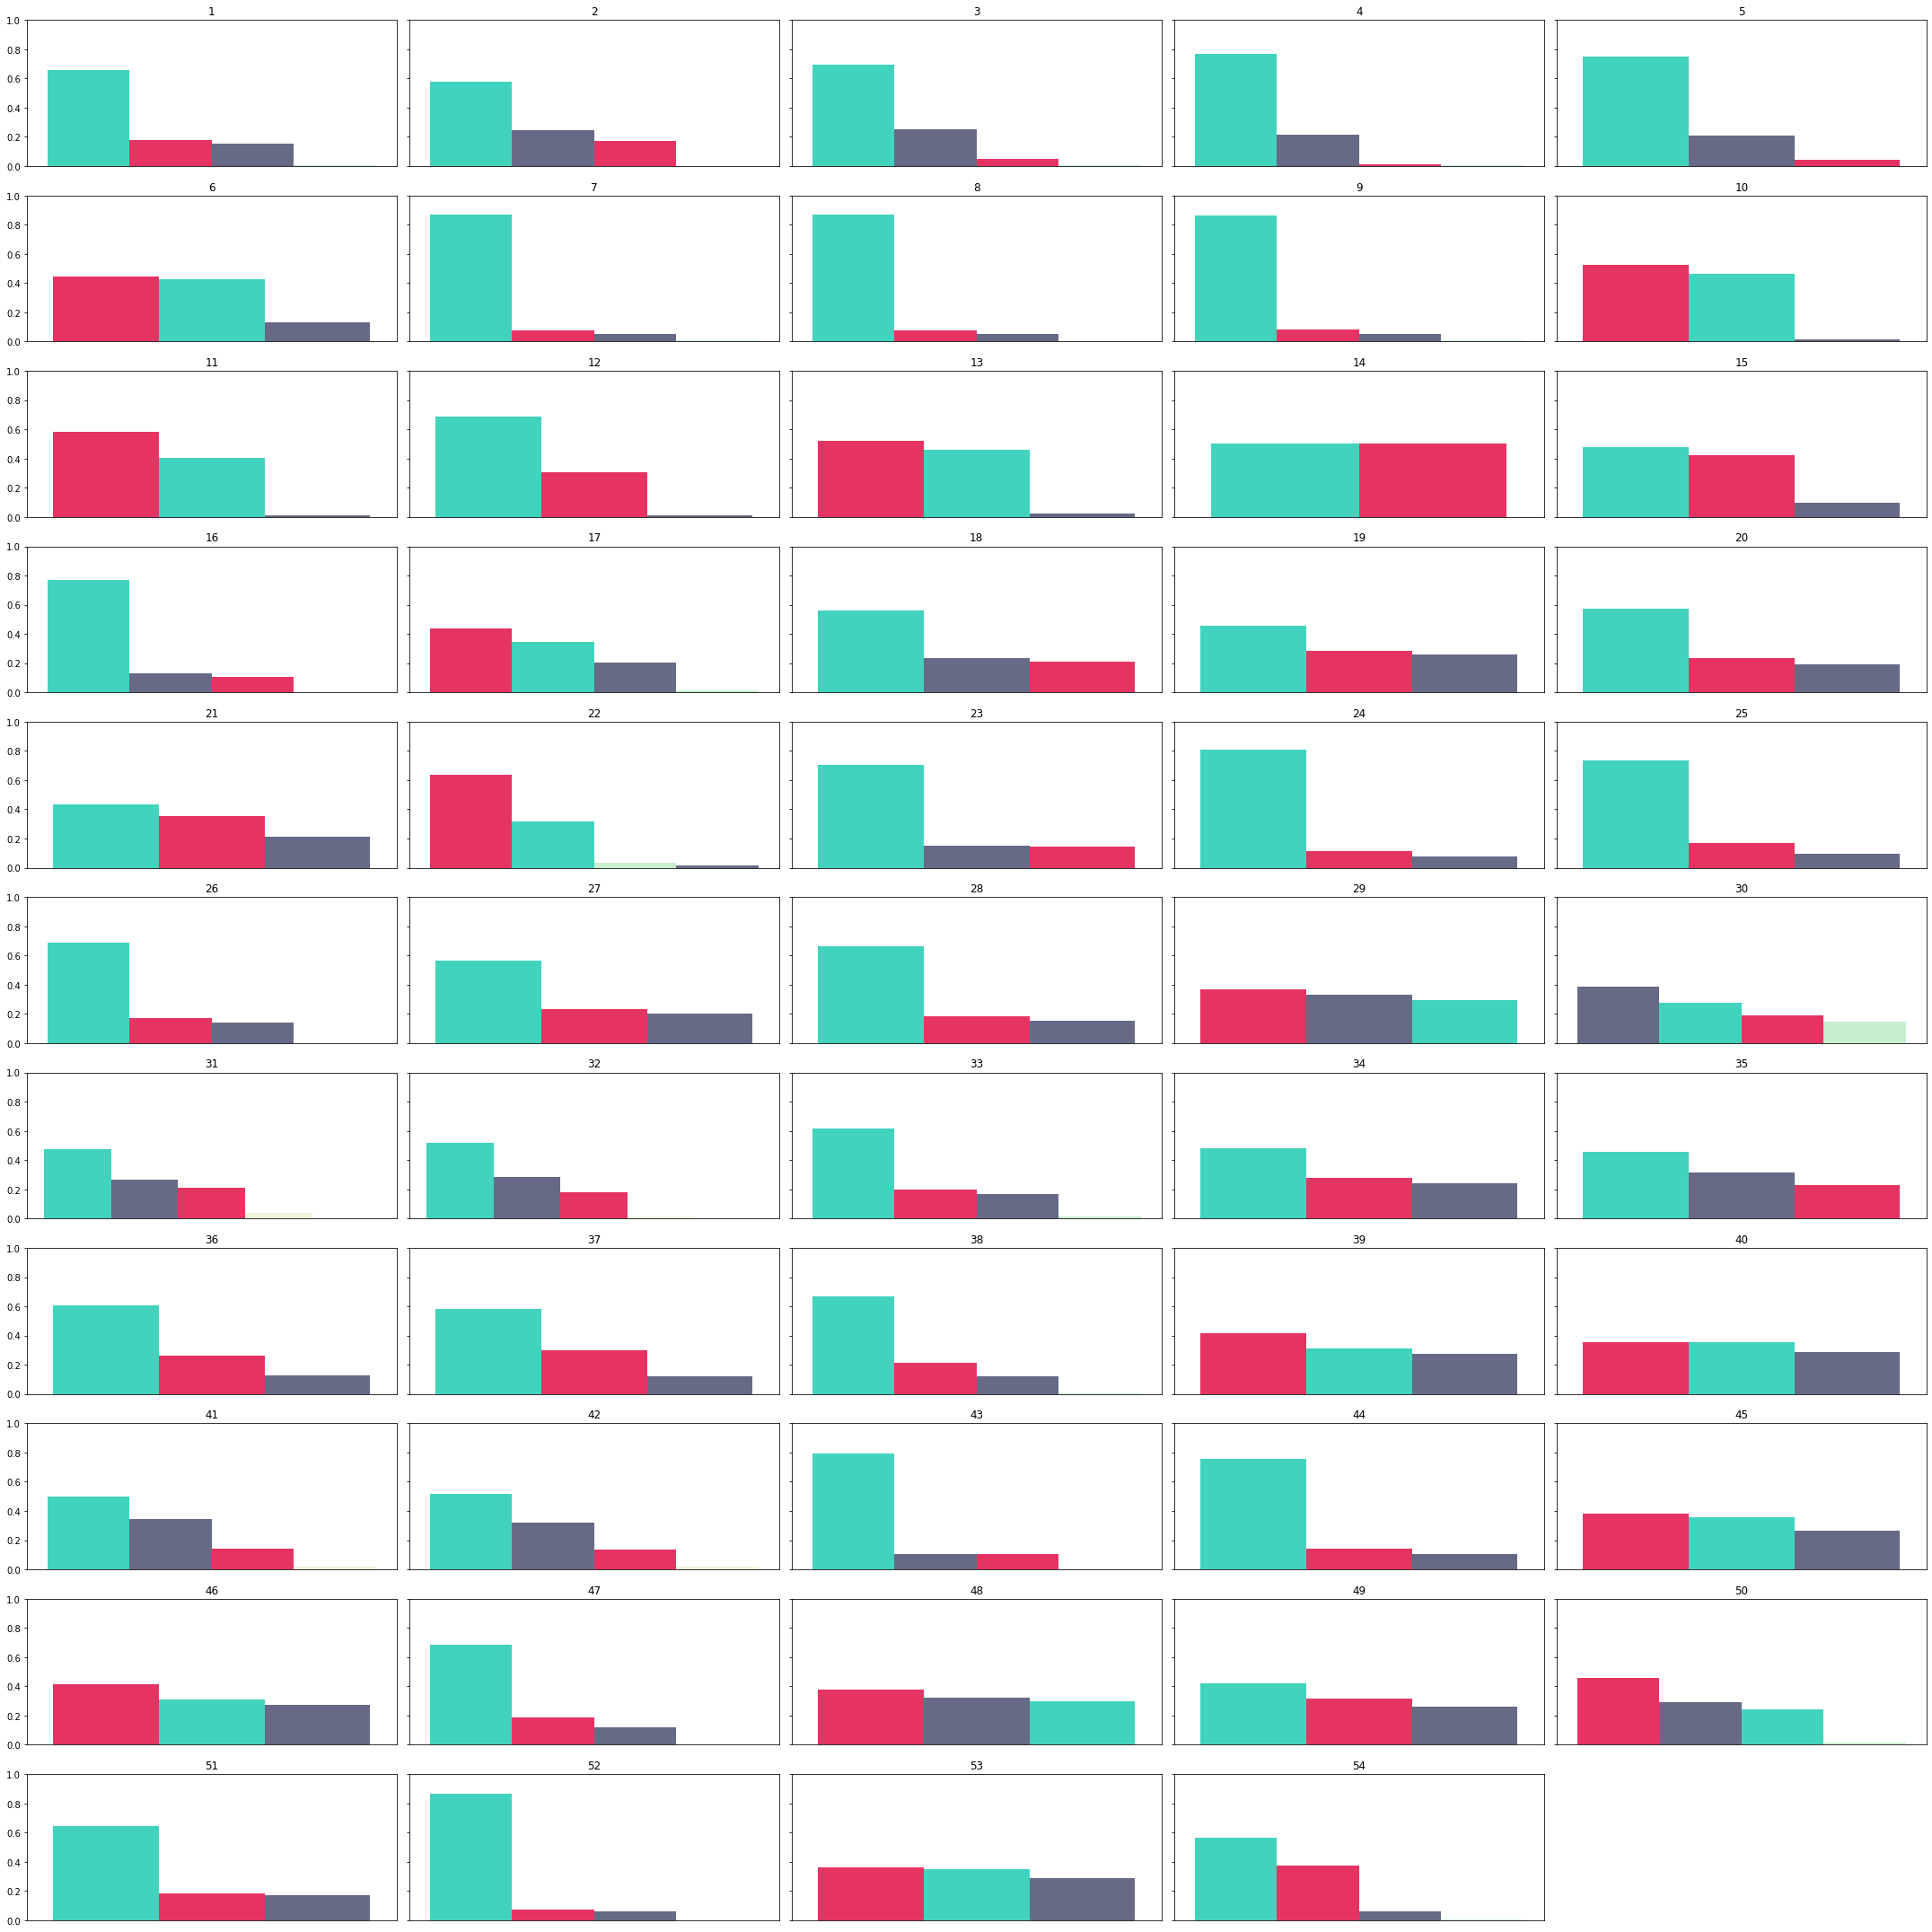

In [19]:
fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(30)
# fig.suptitle('Types of Mutations per Experiment', fontsize=16)

for experiment, num in zip(df["ExperimentID"].unique(), range(1,55)):
  ax = fig.add_subplot(11,5,num)
  Experiment_data = df[df["ExperimentID"] ==experiment]
  total = Experiment_data["TYPE"].value_counts().rename_axis('unique_values').reset_index(name='counts')
  total_valu =total['counts'].sum()
  total["Rel_Dist"] = ""
  values = [0,0,0,0,0]
  for i,row in total.iterrows():
    total.at[i, "Rel_Dist"] = total.loc[i]["counts"] / total_valu
    if total.loc[i]["unique_values"] == "SNP":
      values[0]= (total.loc[i]["Rel_Dist"])
    elif total.loc[i]["unique_values"] == "DEL":
      values[1] = total.loc[i]["Rel_Dist"]
    elif total.loc[i]["unique_values"] == "INS":
      values[2] = total.loc[i]["Rel_Dist"]
    elif total.loc[i]["unique_values"] == "MNV":
      values[3] = total.loc[i]["Rel_Dist"]
    elif total.loc[i]["unique_values"] == "AMP":
      values[4] = total.loc[i]["Rel_Dist"]
  a_series = pd. Series(values, index = pca_mutation_type_df. columns)
  pca_mutation_type_df = pca_mutation_type_df. append(a_series, ignore_index=True)  
  colors = {"SNP": '#41D3BD', "DEL": '#E63462', "INS": '#666A86', "MNV": '#C7EFCF', "AMP": '#EEF5DB'}
  types = list(colors.keys())
  bx = total['Rel_Dist'].plot(kind='bar', width = 1.0, sharey=True, x = 'unique_values', y = 'Rel_Dist', color=[colors[i] for i in total['unique_values']])
  # handles = [plt.Rectangle((0,0),1,1, color=colors[type]) for type in types]
  # plt.legend(handles, types)
  plt.xticks([])
  bx.set_xlabel("")
  bx.set_ylim(0,1)
  ax.set_title(experiment)
# types = list(colors.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors[type]) for type in types]
# fig.legend(handles, types)
fig.tight_layout()

Looking at distributions through PCA to look for interesting different experiments. Make a dataframe with 6 columns? One for each type of mutation with the relative percent in it and do pca on this?

In [20]:
pca_mutation_type_df

,SNP,DEL,INS,MNV,AMP
0,0.658986,0.179724,0.156682,0.004608,0.000000
1,0.579990,0.173184,0.244794,0.002031,0.000000
2,0.694190,0.048930,0.250765,0.006116,0.000000
3,0.765886,0.010033,0.217391,0.006689,0.000000
4,0.748936,0.042553,0.208511,0.000000,0.000000
5,0.425926,0.444444,0.129630,0.000000,0.000000
6,0.867661,0.075910,0.049518,0.006911,0.000000
7,0.868606,0.074432,0.053196,0.003766,0.000000
8,0.862000,0.079265,0.052001,0.006734,0.000000
9,0.460526,0.526316,0.013158,0.000000,0.000000


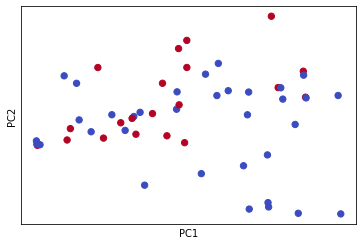

In [21]:
pca = decomposition.PCA(n_components=2)
pca.fit(pca_mutation_type_df)
x = pca.transform(pca_mutation_type_df)
colors = []
for i,row in pca_mutation_type_df.iterrows():
  colors.append(condition[i-1])
plt.scatter(x[:,0], x[:,1], s=40, c = colors, cmap = 'coolwarm')
plt.xticks([])
plt.yticks([])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Look at types of mutations in a heatmap

Text(33.0, 0.5, 'Experiment')

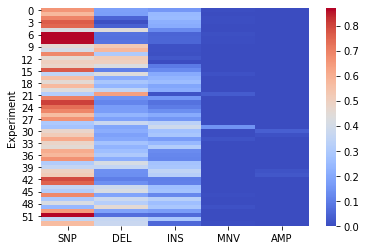

In [22]:
index = list(pca_mutation_type_df.index.values)
seaborn.heatmap(pca_mutation_type_df, cmap='coolwarm')
plt.ylabel("Experiment")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37684a9940>]],
      dtype=object)

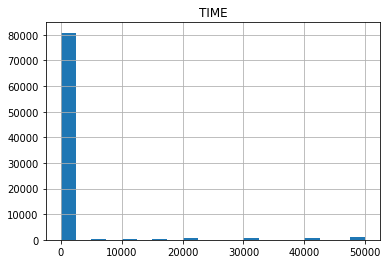

In [23]:
df.hist(column = 'TIME', bins = 20)

Want to get maximum experiment length in flask for each experiment to see experiment length comparisons

A large number of the experiments only recorded one flask so we filter them out since it is an indefinite time

In [0]:
experiment_lengths = []
experiments_with_one = []
experiments_greaterthan200 = []
experiment_min_values = []
counter = 1
while counter < 55:
  experiment_df = df.loc[df["ExperimentID"] == counter]
  experiment_lengths.append(experiment_df["TIME"].max())
  experiment_min_values.append(experiment_df["TIME"].min())
  if experiment_df["TIME"].max() == 1:
    experiments_with_one.append(counter)
  if experiment_df["TIME"].max() > 200:
    experiments_greaterthan200.append(counter)
  counter +=1

# print(experiment_lengths)
# print(experiments_with_one)
# print(experiments_greaterthan200)
# print(experiment_min_values)

Making new dataframe that tracks experiment ID, and max and min length for experiment by flask counts

In [0]:
Experiment_df = pd.DataFrame({"ExperimentID": list(range(1,55)), "Min_Flask": experiment_min_values, "Max_Flask": experiment_lengths})
# print(Experiment_df)

Now we can do a graph showing the experiment length comparisons using flask number as a representation of time. Since a few of our experiments have an insanely high experiment length we need to group them and do a above x count to make the plot work better. We can try the count now at above 200 or could do even lower counts.

In [26]:
for i in range(len(experiment_lengths)):
  if experiment_lengths[i] >= 200:
    experiment_lengths[i] = 200
print(experiment_lengths)   

[164, 1, 44, 28, 26, 135, 1, 1, 1, 184, 171, 113, 142, 178, 89, 1, 88, 15, 118, 90, 78, 200, 200, 9, 36, 71, 114, 200, 40, 200, 200, 200, 50, 50, 57, 92, 165, 165, 45, 113, 1, 1, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 200]


Text(0.5, 0, 'Number of Flasks')

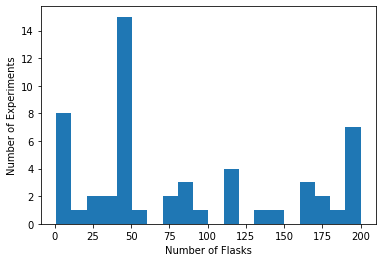

In [27]:
plt.hist(experiment_lengths, bins = 20)
plt.ylabel("Number of Experiments")
plt.xlabel("Number of Flasks")
# plt.title("Experiment Length in Flasks")

Now we trim our experiment list to remove experiments that only report 1 flask time, remove experiments that have a max value of 1 flask. Too difficult to do this as a dataframe because of the weird indexing so we will make it a dictionary.

In [0]:
for i,row in Experiment_df.iterrows():
  if row["Min_Flask"] == row["Max_Flask"]:
    Experiment_df = Experiment_df.drop(i)
Experiment_df = Experiment_df.reset_index(drop=True)
Experiment_dict = {}
for i,row in Experiment_df.iterrows():
  Experiment_dict[Experiment_df.iloc[i]["ExperimentID"]] = [Experiment_df.iloc[i]["Min_Flask"], Experiment_df.iloc[i]["Max_Flask"]]
# print(Experiment_dict)
# Experiment_df

Next step is to create a new column in our dataframe we we use normalized flask values so 1 would be close to 0 and max value would be 1 so we can see how mutations accumulate over time. Need to make new dataframe with mutations that meet the above requirements.

In [29]:
IDs_tokeep = Experiment_df["ExperimentID"].values
Normalization_df = df.loc[df["ExperimentID"].isin(IDs_tokeep)]
Normalization_df = Normalization_df.reset_index(drop=True)
Normalization_df


,CHROM,Start POS,End POS,TYPE,REF,ALT,GEN,∆AA,POP,CLON,TIME,FREQ,COM,ExperimentID,Severity
0,NC_000913,36231,36232.0,SNP,T,C,NaN,NaN,8,1,131,1.0,intergenic (‑69/+40),1,2
1,NC_000913,107553,107554.0,DEL,NaN,NaN,NaN,NaN,3,1,161,1.0,intergenic (+79/‑152),1,2
2,NC_000913,147727,147739.0,DEL,NaN,NaN,yadD,NaN,9,1,153,1.0,coding (760‑771/903 nt),1,2
3,NC_000913,149214,149215.0,SNP,C,T,panB,A130T,2,1,120,1.0,A130T (GCC→ACC),1,2
4,NC_000913,162973,162974.0,SNP,G,A,hrpB,C290Y,6,1,135,1.0,C290Y (TGT→TAT),1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11859,NC_000913,4189448,4189449.0,SNP,C,T,rpoC,Q1367*,2,1,112,1.0,Q1367* (CAG→TAG),40,2
11860,NC_000913,4296381,4296382.0,INS,NaN,GC,NaN,NaN,1,1,109,1.0,intergenic (+587/+55),40,2
11861,NC_000913,4296381,4296382.0,INS,NaN,GC,NaN,NaN,2,1,112,1.0,intergenic (+587/+55),40,2
11862,NC_000913,4296381,4296382.0,INS,NaN,GC,NaN,NaN,3,1,113,1.0,intergenic (+587/+55),40,2


Here we create a new column for normalized time that gives the time point in the experiment. If there is 10 flasks in an experiment than at time 1 we know its 10% through the experiment.

In [0]:
Normalization_df["Normalized_Time"] = ""
for i,row in Normalization_df.iterrows():
  experimentid = Normalization_df.iloc[i]["ExperimentID"]
  min_flask = Experiment_dict.get(experimentid)[0]
  max_flask = Experiment_dict.get(experimentid)[1]
  Normalization_df.at[i, "Normalized_Time"] = (Normalization_df.iloc[i]["TIME"] - min_flask) / (max_flask - min_flask)

In [31]:
Normalization_df

,CHROM,Start POS,End POS,TYPE,REF,ALT,GEN,∆AA,POP,CLON,TIME,FREQ,COM,ExperimentID,Severity,Normalized_Time
0,NC_000913,36231,36232.0,SNP,T,C,NaN,NaN,8,1,131,1.0,intergenic (‑69/+40),1,2,0.25
1,NC_000913,107553,107554.0,DEL,NaN,NaN,NaN,NaN,3,1,161,1.0,intergenic (+79/‑152),1,2,0.931818
2,NC_000913,147727,147739.0,DEL,NaN,NaN,yadD,NaN,9,1,153,1.0,coding (760‑771/903 nt),1,2,0.75
3,NC_000913,149214,149215.0,SNP,C,T,panB,A130T,2,1,120,1.0,A130T (GCC→ACC),1,2,0
4,NC_000913,162973,162974.0,SNP,G,A,hrpB,C290Y,6,1,135,1.0,C290Y (TGT→TAT),1,2,0.340909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11859,NC_000913,4189448,4189449.0,SNP,C,T,rpoC,Q1367*,2,1,112,1.0,Q1367* (CAG→TAG),40,2,0.75
11860,NC_000913,4296381,4296382.0,INS,NaN,GC,NaN,NaN,1,1,109,1.0,intergenic (+587/+55),40,2,0
11861,NC_000913,4296381,4296382.0,INS,NaN,GC,NaN,NaN,2,1,112,1.0,intergenic (+587/+55),40,2,0.75
11862,NC_000913,4296381,4296382.0,INS,NaN,GC,NaN,NaN,3,1,113,1.0,intergenic (+587/+55),40,2,1


In [0]:
yticks =Normalization_df["ExperimentID"].unique()

Now that we have added a normalized value we can look at a density plot for mutations, like how many mutations are there occuring throughout an experiment. Do more mutations occur at the start or end?

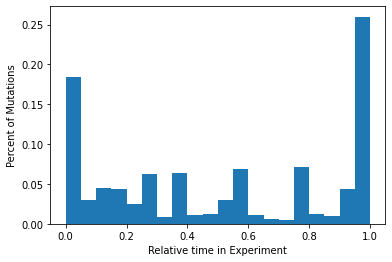

In [33]:
times = Normalization_df["Normalized_Time"].values
weights = np.ones_like(times) / len(times)
plt.hist(times, bins = 20, weights = weights)
plt.ylabel("Percent of Mutations")
plt.xlabel("Relative time in Experiment")
newdf = pd.DataFrame(columns = ["0-20", "20-40", "40-60", "60-80", "80-100"])



Try doing this plot per experiment for comparisons. We start by making a list of the dataframes for each experiment.

In [0]:
Experiment_dataframes = []
for experiment in Experiment_df["ExperimentID"].unique():
  Experiment_dataframes.append(Normalization_df[Normalization_df["ExperimentID"] ==experiment])

<bound method Figure.tight_layout of <Figure size 1800x1800 with 29 Axes>>

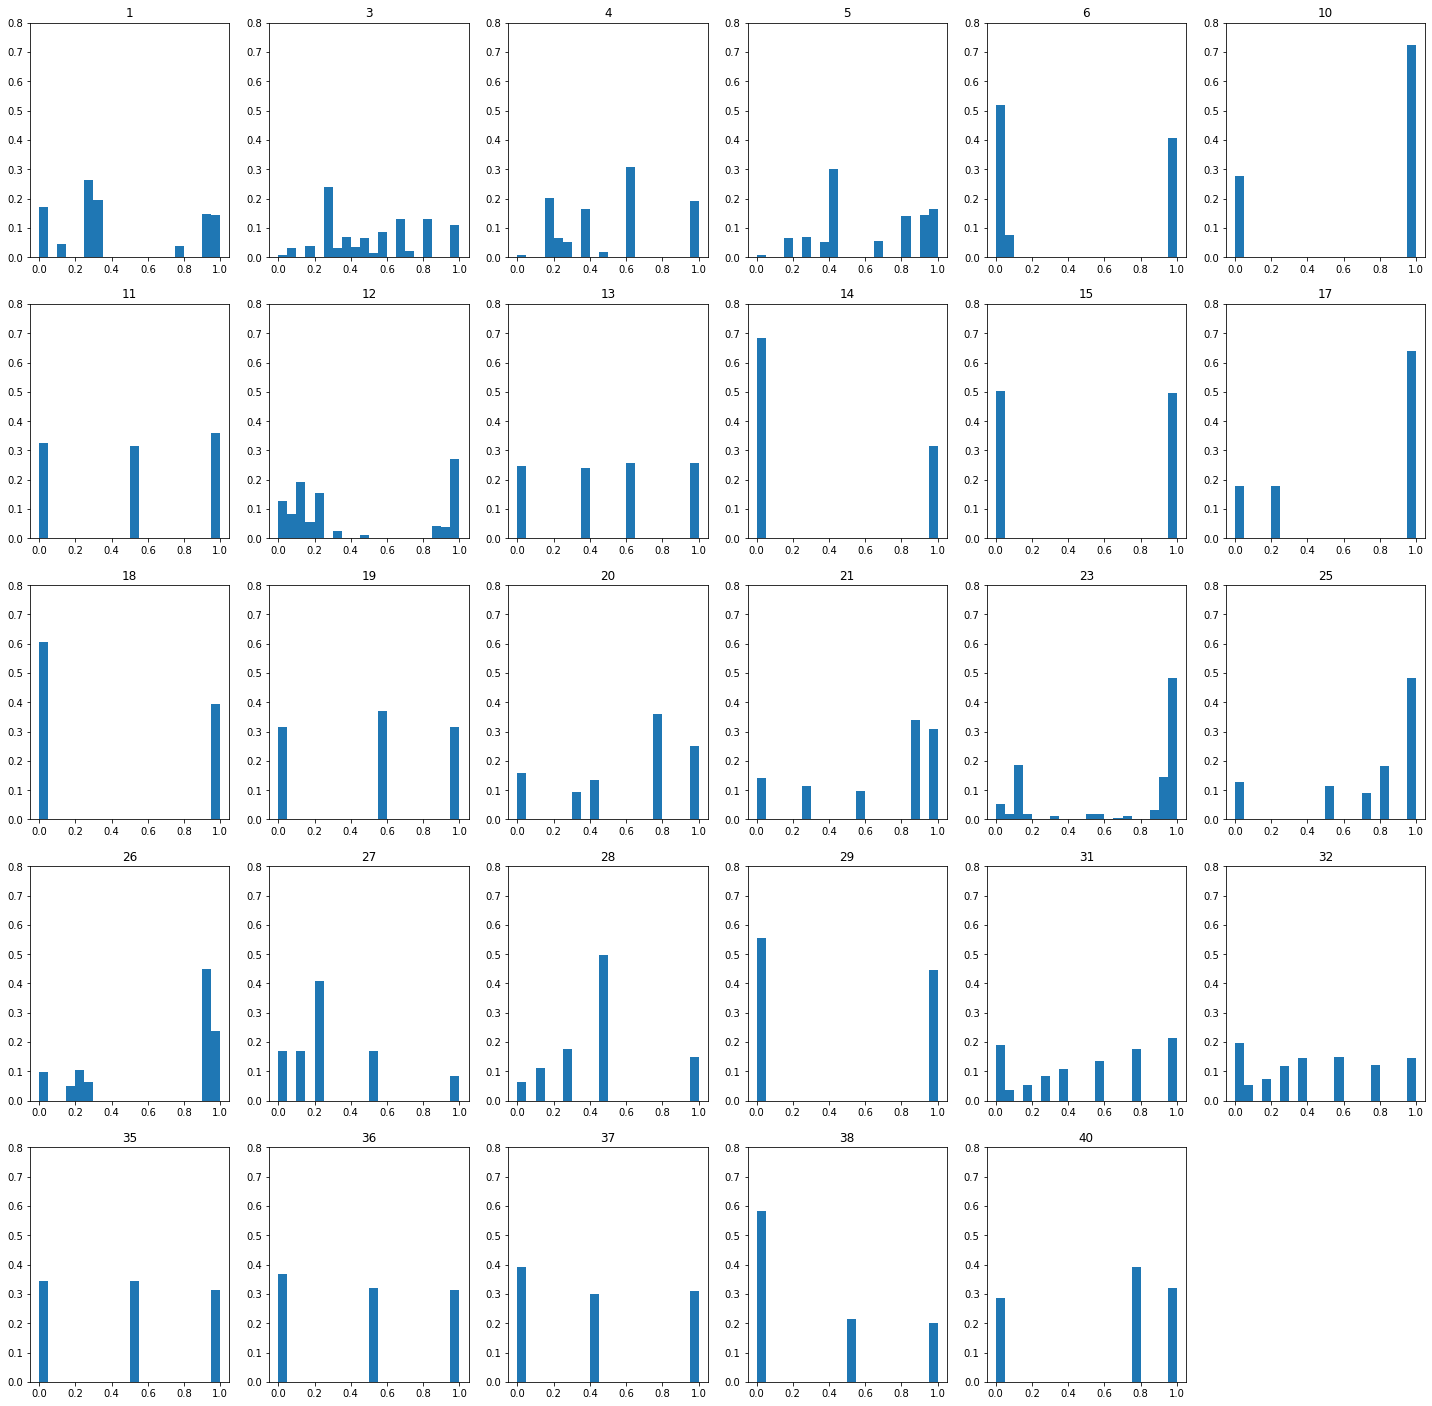

In [35]:
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(25)
# fig.suptitle('Mutation accumulation per experiment', fontsize=16)
for experiment, num in zip(Experiment_df["ExperimentID"].unique(), range(1,30)):
  ax = fig.add_subplot(5,6,num)
  Experiment_data = Normalization_df[Normalization_df["ExperimentID"] ==experiment]
  times = Experiment_data["Normalized_Time"].values
  weights = np.ones_like(times) / len(times)
  plt.hist(times, bins = 20, weights = weights)
  ax.set_ylim([0,.8])
  # plt.hist(Experiment_data["Normalized_Time"], bins = 20, density = True)
  ax.set_title(experiment)
  # plt.ylabel("Number of Mutations")
  # plt.xlabel("Relative time in Experiment")
  # plt.title("Mutation occurrence throughout experiment")
  zeroto20 = 0
  twentyoneto40= 0
  fortyoneto60 = 0
  sixty1to80 = 0
  eighty1to100 = 0

  for i in times:
    if i <= .20:
      zeroto20 +=1
    elif .20 < i <= .40:
      twentyoneto40 +=1
    elif .40 < i <= .60:
      fortyoneto60 +=1
    elif .60 < i < .80:
      sixty1to80 +=1
    else:
      eighty1to100 +=1
  newdf = newdf.append({"0-20": zeroto20/len(times), "20-40": twentyoneto40/len(times), "40-60": fortyoneto60/len(times), "60-80": sixty1to80/len(times), "80-100": eighty1to100/len(times)}, ignore_index=True)
fig.tight_layout

Text(0.5, 50.92999999999999, 'Relative time through Experiment')

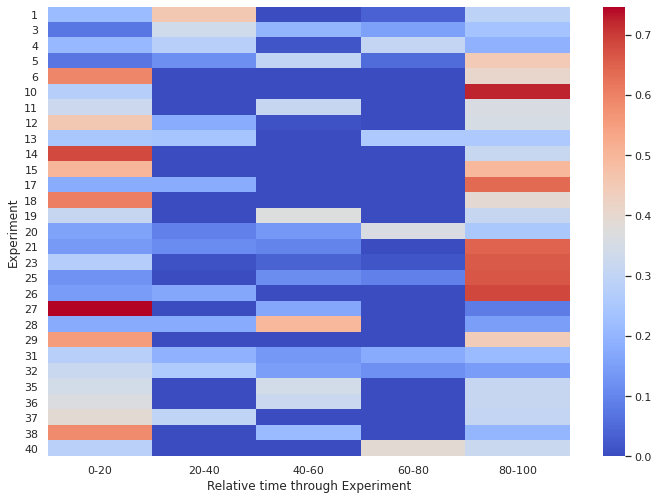

In [36]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
chart = seaborn.heatmap(newdf, cmap='coolwarm', yticklabels=yticks)
chart.set_yticklabels(chart.get_yticklabels(),rotation=0)
plt.ylabel("Experiment")
plt.xlabel("Relative time through Experiment")

Here we are going to look at distribution of intergenic vs non intergenic mutations. Intergenic mutations are represented as NA in the Gene column so we can find the distribution by looking for non NA values in the GEN column.

Text(0.5, 0, '')

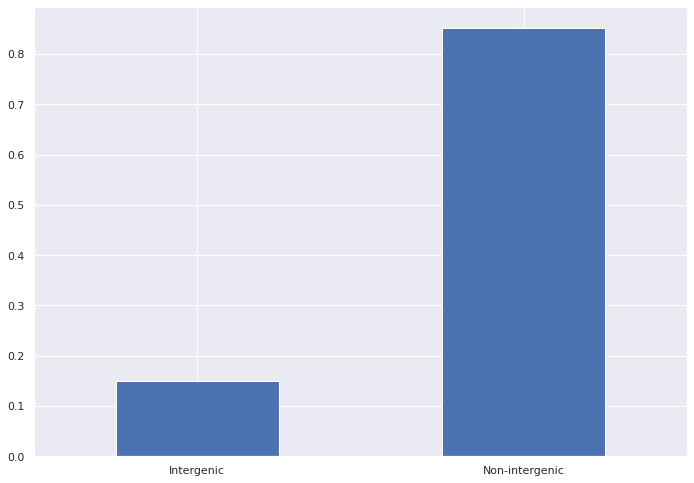

In [37]:
Total_mutations = df.shape[0]
Intergenic = df["GEN"].isna().sum()
Non_intergenic = Total_mutations - Intergenic
Intergenic_perc = Intergenic/Total_mutations
Non_perc = Non_intergenic/Total_mutations
Intergenicdf = pd.DataFrame({'Type':['Intergenic', 'Non-intergenic'], 'Count':[Intergenic_perc, Non_perc]})
ax = Intergenicdf.plot.bar(x='Type', y='Count', rot=0, legend = False)
ax.set_xlabel("")
# plt.title("Distribution of Mutations")

To do this easier we can assign a column to each experiment having a 0 if intergenic and a 1 if not

In [0]:
df["Intergenic_or_not"] = ""
for i,row in df.iterrows():
  if pd.isna(df.iloc[i]["GEN"]):
    df.at[i, "Intergenic_or_not"] = 'Intergenic'
  else:
    df.at[i, "Intergenic_or_not"] = 'Non-intergenic'
df["Intergenic_or_not"] = df.Intergenic_or_not.astype('category')
Intergenic_df_scatter = pd.DataFrame(columns = ["Intergenic_perc", "Non-intergenic_perc"])

Here we can check each experiment individually.

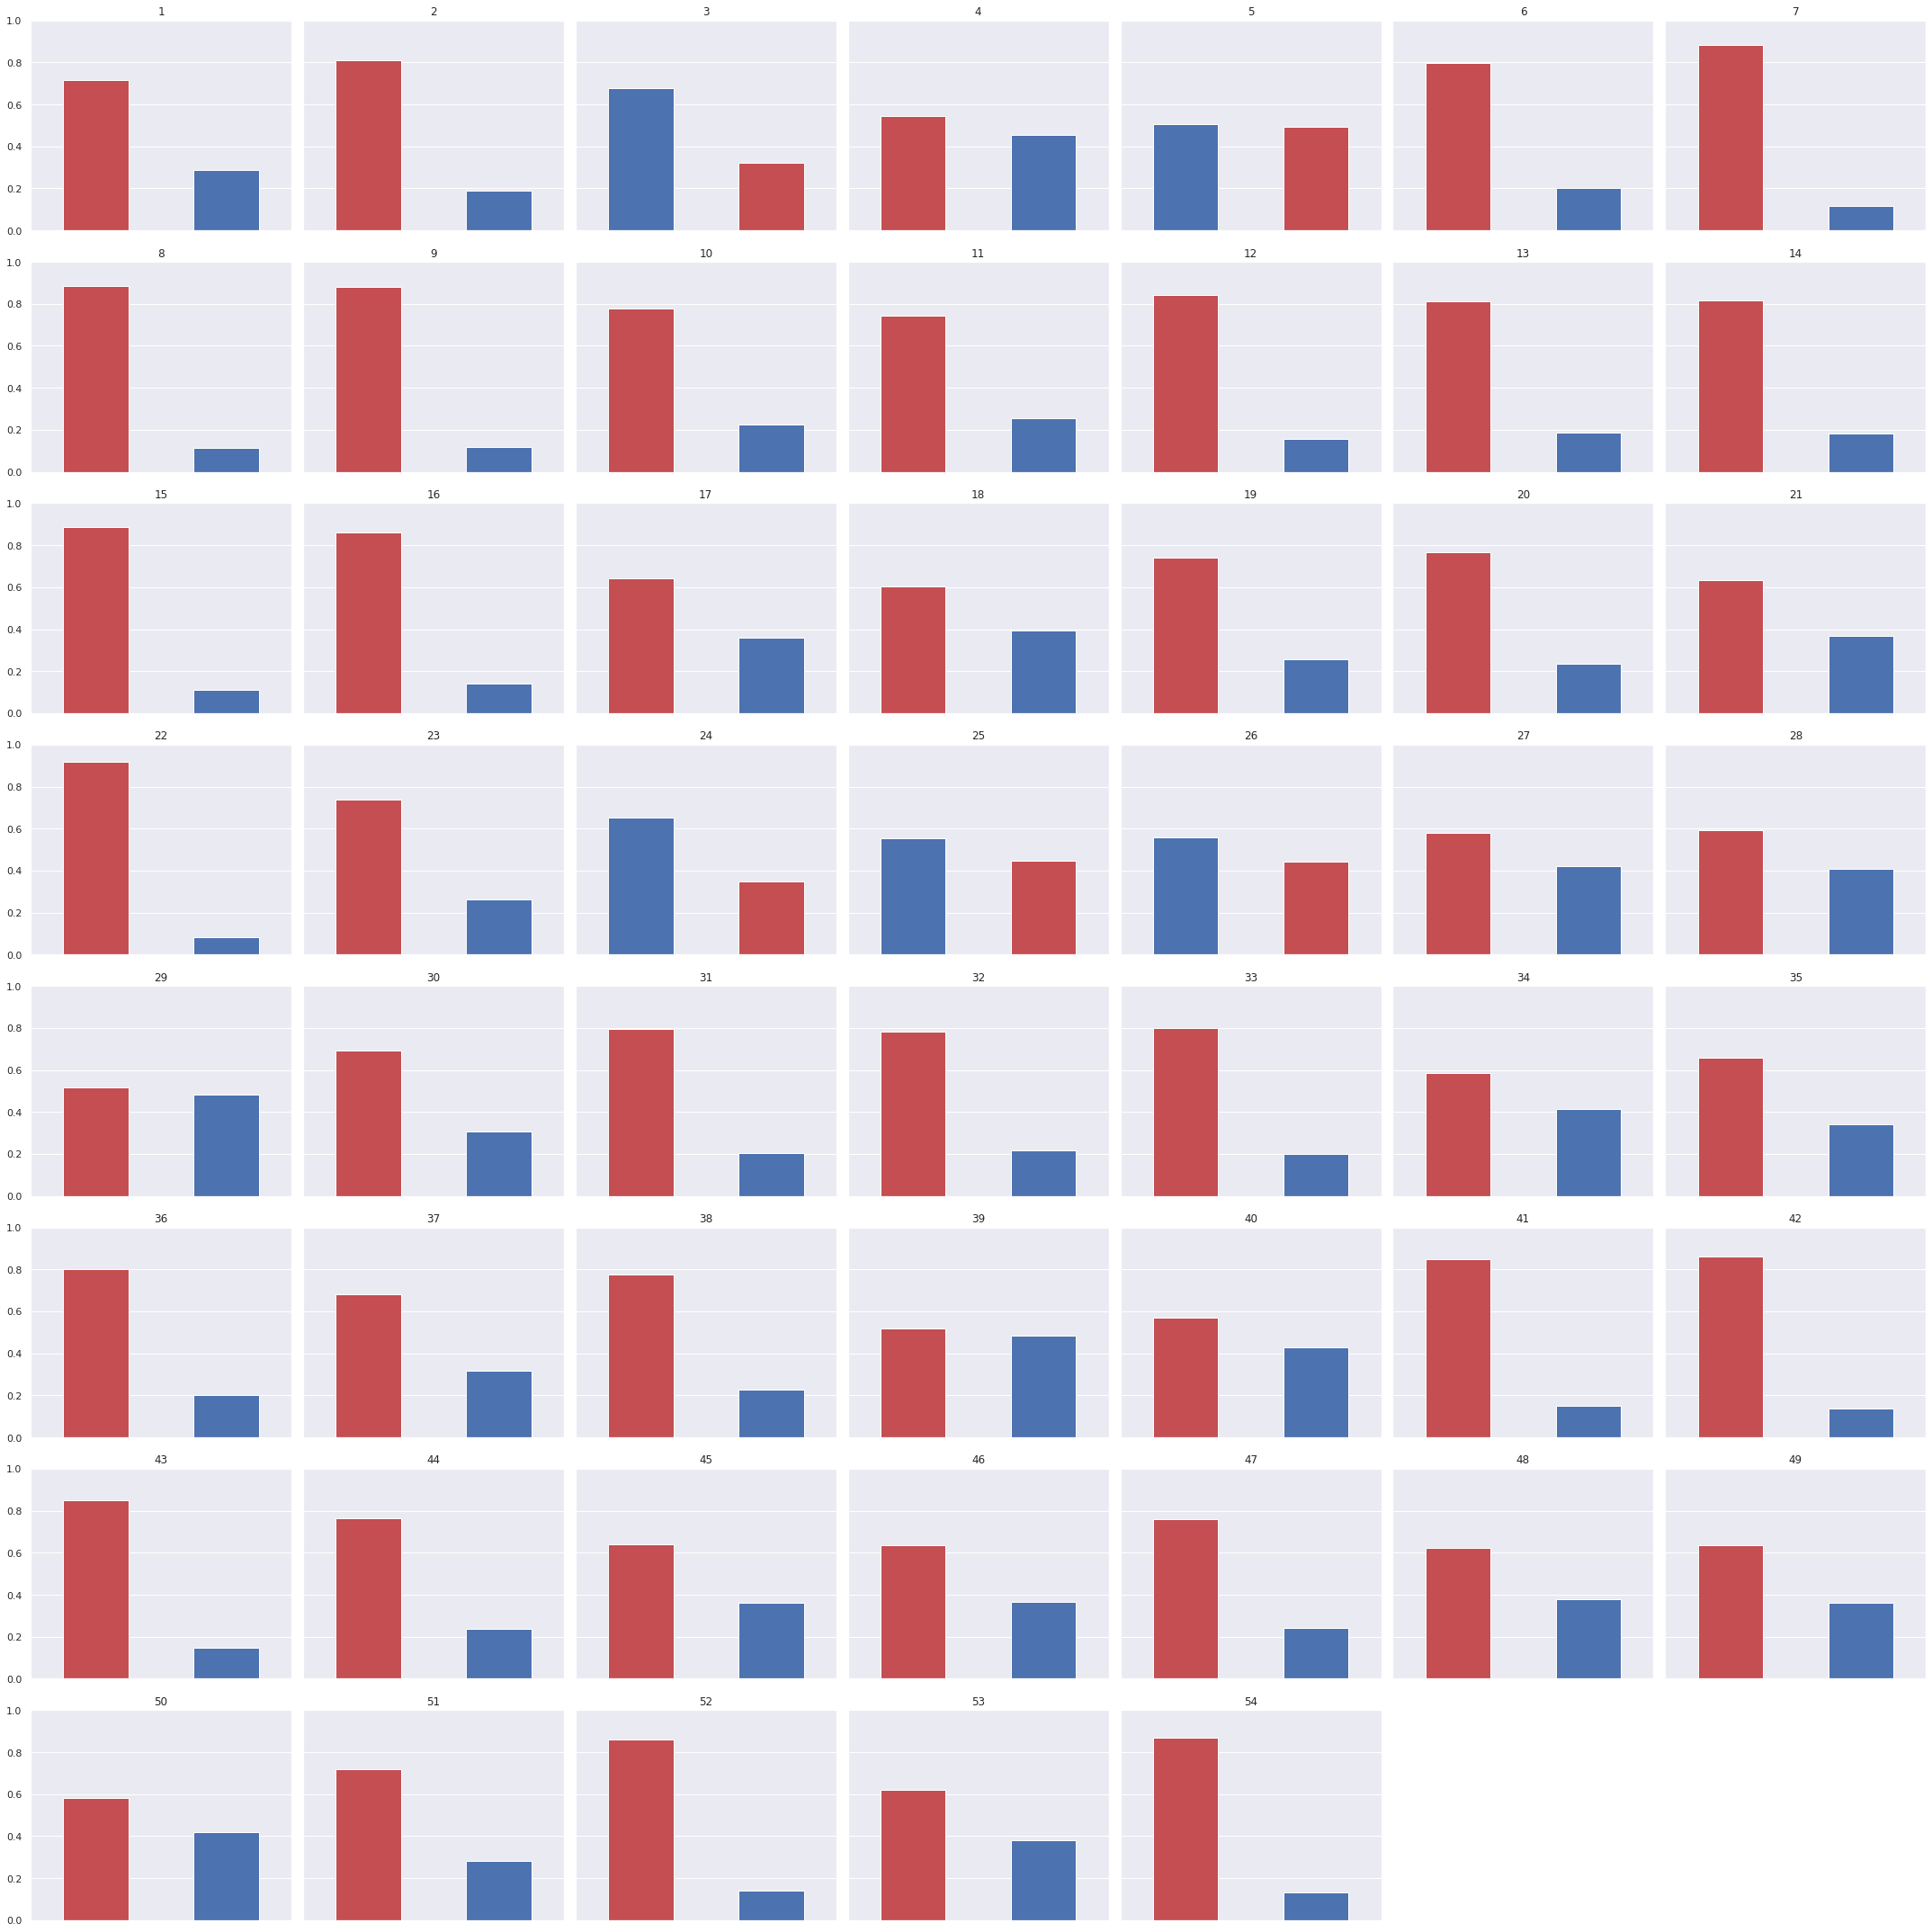

In [39]:
fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(30)
# fig.suptitle('Location of mutations per Experiment', fontsize=16)
for experiment, num in zip(df["ExperimentID"].unique(), range(1,55)): 
  ax = fig.add_subplot(8,7,num)
  values = []
  Experiment_data = df[df["ExperimentID"] ==experiment]
  total = Experiment_data["Intergenic_or_not"].value_counts().rename_axis('unique_values').reset_index(name='counts')
  total_valu =total['counts'].sum()
  total["Rel_Dist"] = ""
  total.at[0, "Rel_Dist"] = total.loc[0]["counts"] / total_valu
  total.at[1, "Rel_Dist"] = total.loc[1]["counts"] / total_valu
  values.append(total.loc[0]["Rel_Dist"])
  values.append(total.loc[1]["Rel_Dist"])
  colors = {"Non-intergenic": 'r', "Intergenic": 'b'}
  types = list(colors.keys())
  ax = total['Rel_Dist'].plot(kind='bar', sharey=True, width = .5, x = 'unique_values', y = 'Rel_Dist', color=[colors[i] for i in total['unique_values']])
  handles = [plt.Rectangle((0,0),1,1, color=colors[type]) for type in types]
  plt.xticks([])
  ax.set_xlabel("")
  ax.set_ylim(0,1)
  ax.set_title(experiment)
  a_series = pd. Series(values, index = Intergenic_df_scatter. columns)
  Intergenic_df_scatter = Intergenic_df_scatter. append(a_series, ignore_index=True)
# fig.legend(handles, types)
fig.tight_layout()

Now we want to check if some genes are more likely to be targets of mutations than others.First step is to remove NaNs, then to make mutations with multiple genes separated by a comma added.

We can make a scatter plot of these values too to see in a different way how experiments are different.

In [40]:
Intergenic_df_scatter

,Intergenic_perc,Non-intergenic_perc
0,0.714286,0.285714
1,0.810564,0.189436
2,0.678899,0.321101
3,0.545151,0.454849
4,0.506383,0.493617
5,0.796296,0.203704
6,0.883006,0.116994
7,0.885134,0.114866
8,0.882248,0.117752
9,0.776316,0.223684


Text(0, 0.5, 'Percent Intergenic')

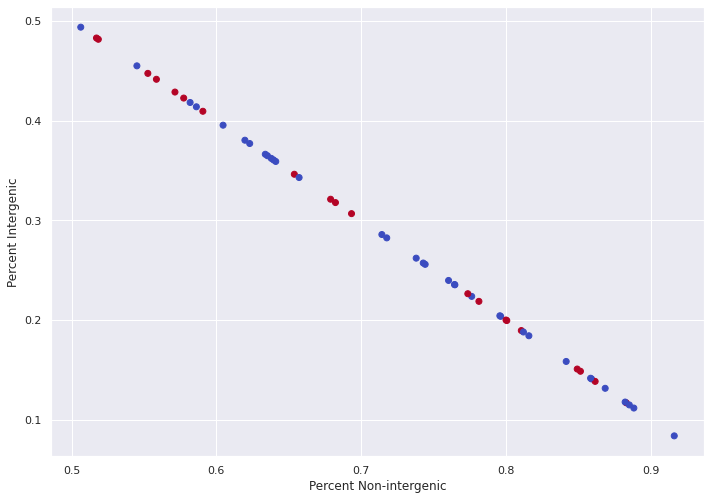

In [41]:
colors = []
for i,row in pca_mutation_type_df.iterrows():
  colors.append(condition[i-1])
plt.scatter(Intergenic_df_scatter["Intergenic_perc"], Intergenic_df_scatter["Non-intergenic_perc"], c = colors, cmap = 'coolwarm')
plt.xlabel("Percent Non-intergenic")
plt.ylabel("Percent Intergenic")

In [0]:
genes = []
Non_intergenic_mutations = df[df['GEN'].notna()]
Non_intergenic_mutations = Non_intergenic_mutations.reset_index(drop=True)
for i, row in Non_intergenic_mutations.iterrows():
  if "," in Non_intergenic_mutations.iloc[i]["GEN"]:
    gene_list = Non_intergenic_mutations.iloc[i]["GEN"].split(",")
    for i in gene_list:
        genes.append(i)
  else:
    genes.append(Non_intergenic_mutations.iloc[i]["GEN"])

Only include genes that appear more than one time.

---



Text(0, 0.5, 'Count')

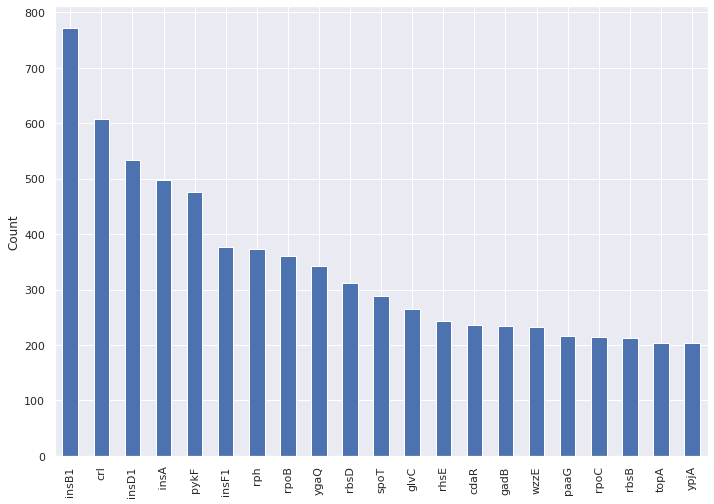

In [43]:
pd.Series(genes).value_counts()[lambda x : x>200].plot(kind = 'bar')
#  figsize = (30,10)
plt.ylabel("Count")

Next step is to use a blossum matrix to get a score for SNPs and the amino acid they change to. Can do two different approaches. First is look at all mutations with amino acid information in df and just plot the scores. Second is use normalization_df and look at scores relative to mutation time to see if more drastic changes happen at the start or end of the experiment. I will use the blossum 50 matrix for scoring.

In [0]:
Aminoacid_df = df[df['∆AA'].notna()]
Normalized_amino_df = Normalization_df[Normalization_df["∆AA"].notna()]
Aminoacid_df = Aminoacid_df.reset_index(drop=True)
Normalized_amino_df = Normalized_amino_df.reset_index(drop=True)

In [45]:
Aminoacid_df

,CHROM,Start POS,End POS,TYPE,REF,ALT,GEN,∆AA,POP,CLON,TIME,FREQ,COM,ExperimentID,Severity,Intergenic_or_not
0,NC_000913,149214,149215.0,SNP,C,T,panB,A130T,2,1,120,1.0,A130T (GCC→ACC),1,2,Non-intergenic
1,NC_000913,162973,162974.0,SNP,G,A,hrpB,C290Y,6,1,135,1.0,C290Y (TGT→TAT),1,2,Non-intergenic
2,NC_000913,162973,162974.0,SNP,G,A,hrpB,C290Y,8,1,131,1.0,C290Y (TGT→TAT),1,2,Non-intergenic
3,NC_000913,216568,216569.0,SNP,C,T,yaeF,A146T,8,1,131,1.0,A146T (GCC→ACC),1,2,Non-intergenic
4,NC_000913,219624,219625.0,SNP,A,G,rcsF,C124C,2,1,120,1.0,C124C (TGT→TGC),1,2,Non-intergenic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60214,NC_007779,4405094,4405095.0,SNP,G,A,hfq,V43M,22,1,2000,1.0,V43M (GTG→ATG),54,1,Non-intergenic
60215,NC_007779,4626165,4626166.0,SNP,C,G,deoD,C201W,21,1,2000,1.0,C201W (TGC→TGG),54,1,Non-intergenic
60216,NC_007779,4639891,4639892.0,SNP,A,G,robA,S34P,20,1,2000,1.0,S34P (TCC→CCC),54,1,Non-intergenic
60217,NC_007779,4639891,4639892.0,SNP,A,G,robA,S34P,21,2,2000,1.0,S34P (TCC→CCC),54,1,Non-intergenic


Need to make nested dictionary for scoring values. Using Biopython Blosum50 matrix dictionary

In [0]:
# MatrixInfo.blosum50

In [0]:
Aminoacid_df["AA1"] = ""
Aminoacid_df["AA2"] = ""
Aminoacid_df["Score"] = ""
for i,row in Aminoacid_df.iterrows():
  AA1 = Aminoacid_df.iloc[i]["∆AA"][0].upper()
  AA2 = Aminoacid_df.iloc[i]["∆AA"][-1].upper()
  Aminoacid_df.at[i, "AA1"] = AA1
  Aminoacid_df.at[i, "AA2"] = AA2
Normalized_amino_df["AA1"] = ""
Normalized_amino_df["AA2"] = ""
for i,row in Normalized_amino_df.iterrows():
  AA1 = Normalized_amino_df.iloc[i]["∆AA"][0].upper()
  AA2 = Normalized_amino_df.iloc[i]["∆AA"][-1].upper()
  Normalized_amino_df.at[i, "AA1"] = AA1
  Normalized_amino_df.at[i, "AA2"] = AA2

In [0]:
# Aminoacid_df

In [0]:
Aminoacid_df = Aminoacid_df[Aminoacid_df['AA1'] != '*']
Aminoacid_df = Aminoacid_df[Aminoacid_df['AA2'] != '*']
Aminoacid_df = Aminoacid_df.reset_index(drop=True)
# Aminoacid_df

In [0]:
Normalized_amino_df = Normalized_amino_df[Normalized_amino_df.AA1 != '*']
Normalized_amino_df = Normalized_amino_df[Normalized_amino_df.AA2 != '*']

Normalized_amino_df = Normalized_amino_df.reset_index(drop=True)

for i,row in Aminoacid_df.iterrows():
  AA1 = Aminoacid_df.iloc[i]["∆AA"][0].upper()
  AA2 = Aminoacid_df.iloc[i]["∆AA"][-1].upper()
  try:
    Aminoacid_df.at[i, "Score"] = MatrixInfo.blosum50[AA1, AA2]
  except:
    Aminoacid_df.at[i, "Score"] = MatrixInfo.blosum50[AA2, AA1]
for i,row in Normalized_amino_df.iterrows():
  AA1 = Normalized_amino_df.iloc[i]["∆AA"][0].upper()
  AA2 = Normalized_amino_df.iloc[i]["∆AA"][-1].upper()
  try:
    Normalized_amino_df.at[i, "Score"] = MatrixInfo.blosum50[AA1,AA2]
  except:
    Normalized_amino_df.at[i, "Score"] = MatrixInfo.blosum50[AA2,AA1]


In [0]:
# Aminoacid_df

Now we can graph this for all experiments and per experiment

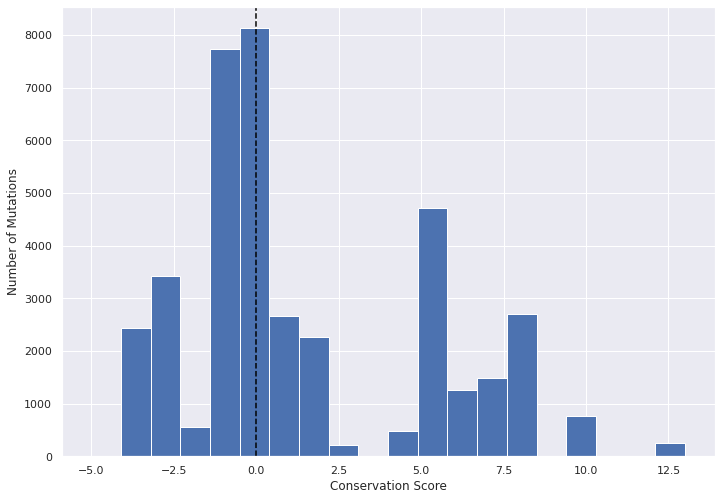

In [52]:
plt.hist(Aminoacid_df["Score"], bins = 20)
plt.ylabel("Number of Mutations")
plt.xlabel("Conservation Score")
plt.axvline(x=0,color='black',linestyle='--')


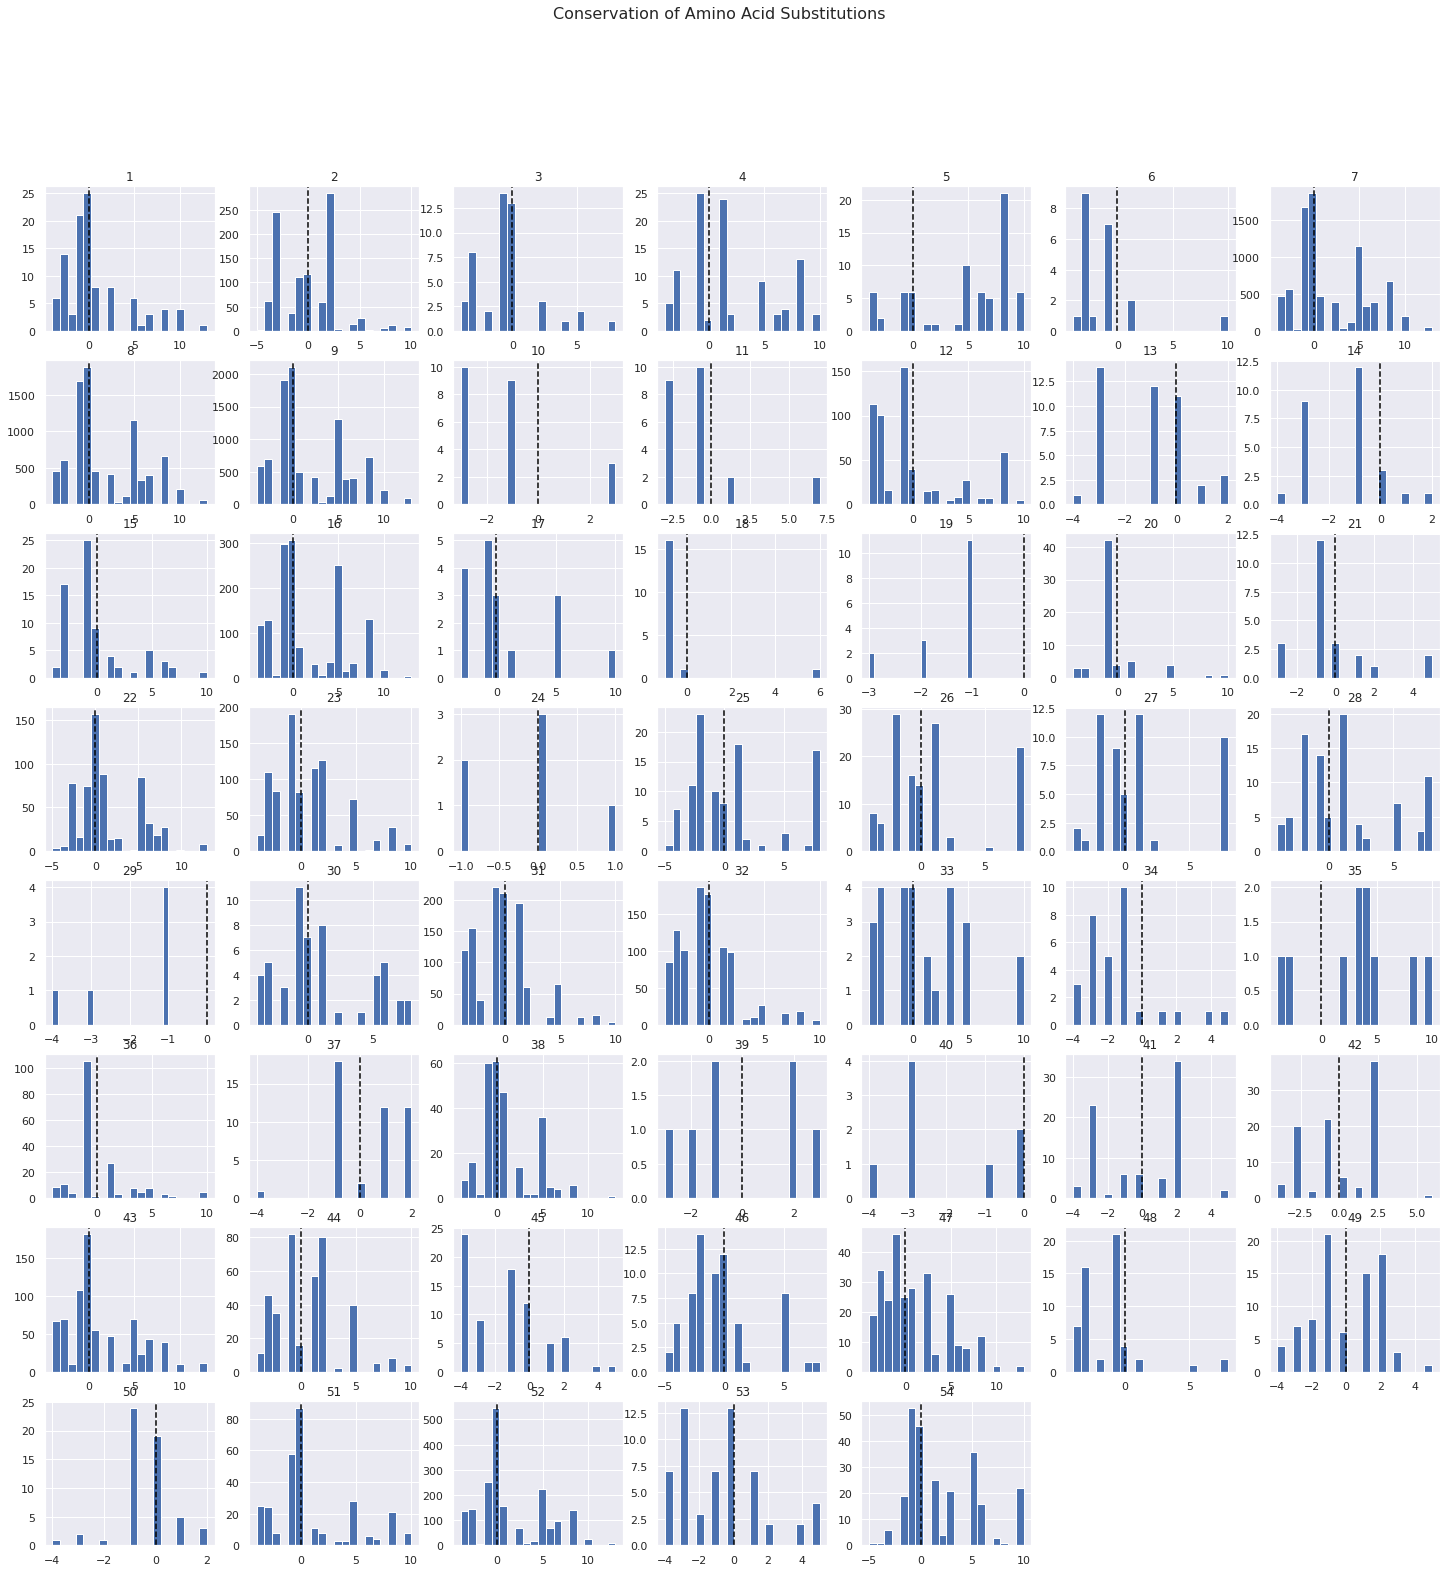

In [53]:
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(25)
fig.suptitle('Conservation of Amino Acid Substitutions', fontsize=16)
for experiment, num in zip(df["ExperimentID"].unique(), range(1,55)):
  ax = fig.add_subplot(8,7,num)
  Experiment_data = Aminoacid_df[Aminoacid_df["ExperimentID"] ==experiment]
  plt.hist(Experiment_data["Score"], bins = 20)
  ax.set_title(experiment)
  plt.axvline(x=0,color='black',linestyle='--')
  # plt.ylabel("Number of Mutations")
  # plt.xlabel("Relative time in Experiment")
  # plt.title("Mutation occurrence throughout experiment")

Now we can look at the normalized time dataframe to see conservation scores throughout the experiment. One way to do this is to split our data into two dataframes, one with mutations less than 50% through the experiment and the other greater.

In [0]:
First_half = Normalized_amino_df[Normalized_amino_df['Normalized_Time'] <= .50]
Second_half = Normalized_amino_df[Normalized_amino_df['Normalized_Time'] > .50]
First_half = First_half.reset_index(drop=True)
Second_half = Second_half.reset_index(drop=True)

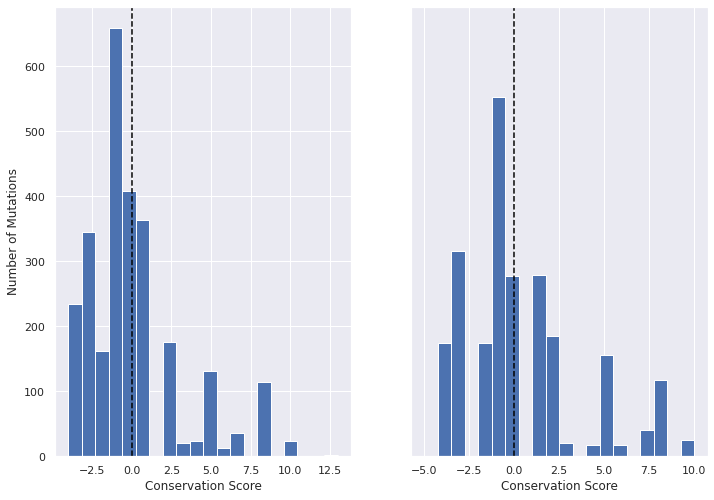

In [55]:
plt.subplot(1,2,1)
plt.hist(First_half["Score"], bins = 20)
plt.ylabel("Number of Mutations")
plt.xlabel("Conservation Score")
plt.axvline(x=0,color='black',linestyle='--')

# plt.title("Conservation of Amino Acid Substitutions")

ax = plt.subplot(1,2,2)
plt.hist(Second_half["Score"], bins = 20)
# plt.ylabel("Number of Mutations")
plt.xlabel("Conservation Score")
ax.set_ylim(0,700)
plt.yticks([])
plt.axvline(x=0,color='black',linestyle='--')

# plt.title("Conservation of Amino Acid Substitutions")

In [0]:
# plt.hist(Second_half["Score"], bins = 20)
# plt.ylabel("Number of Mutations")
# plt.xlabel("Conservation Score")
# plt.title("Conservation of Amino Acid Substitutions")

We can also do this comparison for each experiment. But I can wait for Brams response and ask about this approach.

# Looking at CAMEL database experiments

Breakdown of CAMEL database and WGS, 136 experiments using WGS out of 632 experiments.

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <a list of 10 Text major ticklabel objects>)

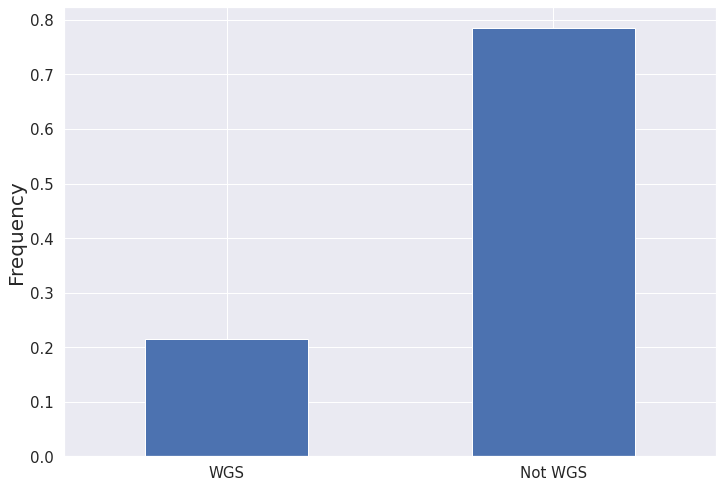

In [57]:
WGS = 136
Not = 632-136
Total_count = 632
WGS_perc = WGS/Total_count
Not_perc = Not/Total_count
WGSdf = pd.DataFrame({'Type':['WGS', 'Not WGS'], 'Count':[WGS_perc, Not_perc]})
ax = WGSdf.plot.bar(x='Type', y='Count', rot=0, legend = False)
ax.set_xlabel("")
plt.ylabel("Frequency", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# plt.title("Distribution of Mutations")

WGS methods used in CAMEL

Text(0, 0.5, 'Count')

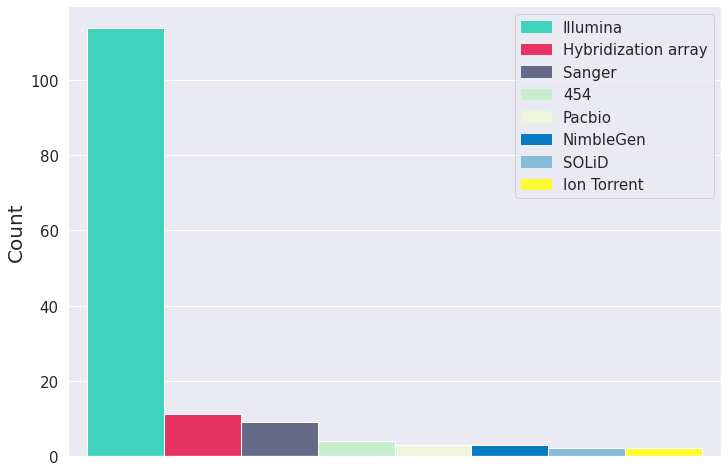

In [58]:
WGSdf_tech = pd.DataFrame({'Technology':['Illumina', 'Hybridization array', 'Sanger', '454', 'Pacbio', 'NimbleGen', 'SOLiD', 'Ion Torrent'], 'Count':[114, 11, 9, 4, 3, 3, 2, 2]})

colors = {'Illumina':'#41D3BD', 'Hybridization array':'#E63462', 'Sanger': '#666A86', '454': '#C7EFCF', "Pacbio": "#EEF5DB", "NimbleGen": '#067BC2', "SOLiD": '#84BCDA', "Ion Torrent": '#FFFC31'}         
ax = WGSdf_tech.plot.bar(x='Technology', y='Count', rot=0, color=[colors[i] for i in WGSdf_tech['Technology']], width = 1)
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, fontsize = 15)
plt.xticks([])
ax.set_xlabel("")
plt.yticks(fontsize = 15)
plt.ylabel("Count", fontsize = 20)


Upload files for next parts

In [60]:
uploaded2 = files.upload()

Saving generations.json to generations.json
Saving numberofdays.json to numberofdays.json
Saving numberoflines.json to numberoflines.json
Saving referenceyears.json to referenceyears.json
Saving WGSperyearcount to WGSperyearcount


First graph will be on number of lines in Experiment. Upload json results from API with number of lines per experiment

In [0]:
numlines = pd.read_json("/content/numberoflines.json")

In [62]:
numlines = numlines["values"]
numlines

0     {'value': 12, 'number': 24}
1     {'value': 24, 'number': 21}
2      {'value': 1, 'number': 15}
3      {'value': 2, 'number': 13}
4      {'value': 6, 'number': 12}
                 ...             
63    {'value': 102, 'number': 1}
64    {'value': 746, 'number': 1}
65    {'value': 200, 'number': 1}
66    {'value': 100, 'number': 1}
67     {'value': 28, 'number': 1}
Name: values, Length: 68, dtype: object

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 9 Text major ticklabel objects>)

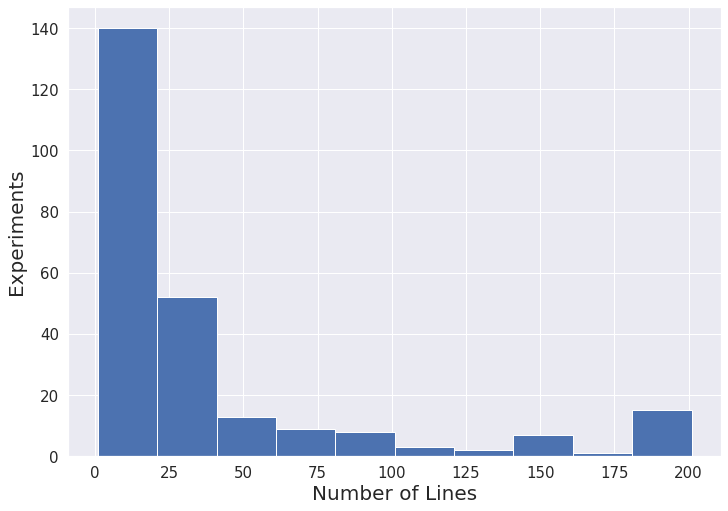

In [63]:
linesdataframe = pd.DataFrame(columns = ["Number of lines", "Count"])
for i in numlines:
  linesdataframe = linesdataframe.append({"Number of lines": i["value"], "Count": i["number"]}, ignore_index=True)
linesdataframe
linevalues = []
for i, row in linesdataframe.iterrows():
  linevalues += [row["Number of lines"]] * row["Count"]
#Make values greater than 200 = to 200 then have them say greater than 200.
for idx, item in enumerate(linevalues):
  if item > 200:
    linevalues[idx] = 201
plt.hist(linevalues)
plt.ylabel("Experiments", fontsize = 20)
plt.xlabel("Number of Lines", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

Second is Experiment Length in days


(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text major ticklabel objects>)

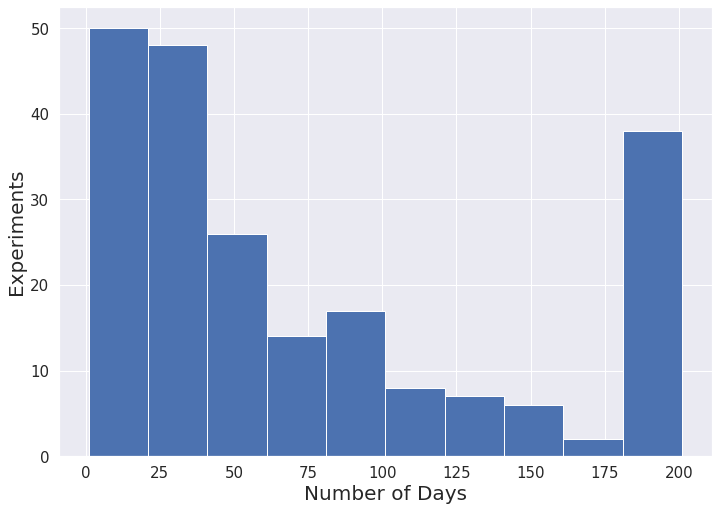

In [64]:
numdays = pd.read_json("/content/numberofdays.json")
numdays=numdays["values"]
daysdataframe = pd.DataFrame(columns = ["Number of Days", "Count"])
for i in numdays:
  daysdataframe = daysdataframe.append({"Number of Days": i["value"], "Count": i["number"]}, ignore_index=True)
daysdataframe
dayvalues = []
for i, row in daysdataframe.iterrows():
  dayvalues += [row["Number of Days"]] * row["Count"]
#Make values greater than 200 = to 200 then have them say greater than 200.
for idx, item in enumerate(dayvalues):
  if item > 200:
    dayvalues[idx] = 201
plt.hist(dayvalues)
plt.ylabel("Experiments", fontsize = 20)
plt.xlabel("Number of Days", fontsize =20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

Third is Number of generations

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text major ticklabel objects>)

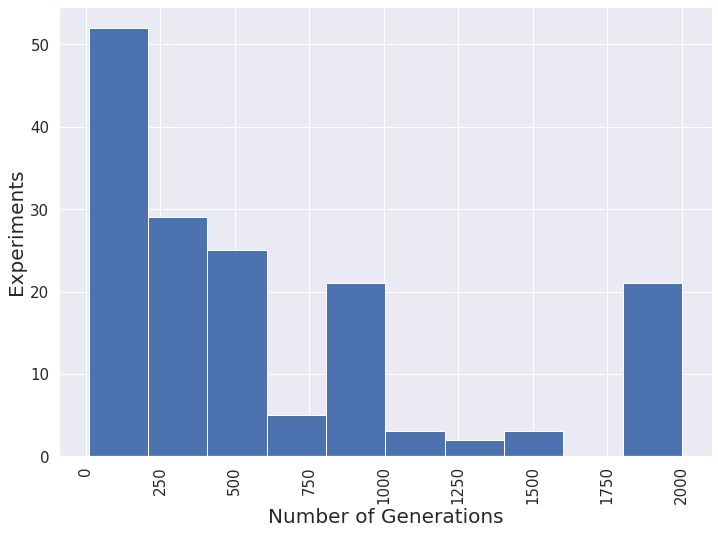

In [65]:
numgens = pd.read_json("/content/generations.json")
numgens=numgens["values"]
gendataframe = pd.DataFrame(columns = ["Number of Generations", "Count"])
for i in numgens:
  gendataframe = gendataframe.append({"Number of Generations": i["value"], "Count": i["number"]}, ignore_index=True)
genvalues = []
for i, row in gendataframe.iterrows():
  genvalues += [row["Number of Generations"]] * int(row["Count"])
#Make values greater than 200 = to 200 then have them say greater than 200.
for idx, item in enumerate(genvalues):
  if item > 2000:
    genvalues[idx] = 2001
plt.hist(genvalues)
plt.ylabel("Experiments", fontsize = 20)
plt.xlabel("Number of Generations", fontsize = 20)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)

WGS per year

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 <a list of 8 Text major ticklabel objects>)

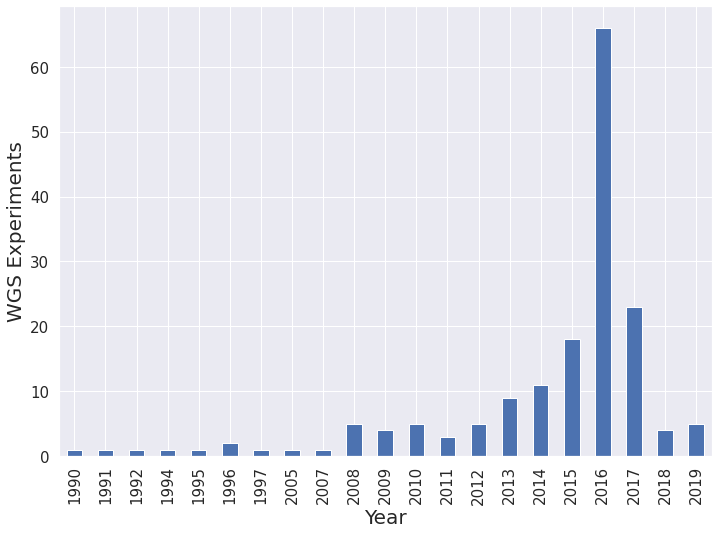

In [66]:
wgsperyear = pd.read_csv("/content/WGSperyearcount")
wgsvalues = pd.DataFrame(columns = ["Year", "Count"])
for i, row in wgsperyear.iterrows():
  val = row[0]
  wgsvalues = wgsvalues.append({"Year": int(val.split("\t")[0]), "Count": int(val.split("\t")[1])}, ignore_index=True)
wgsvalues
ax = wgsvalues.plot.bar(x = "Year", legend = False)
ax.set_ylabel("WGS Experiments", fontsize = 20)
ax.set_xlabel("Year", fontsize = 20)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)

Experiments per year

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

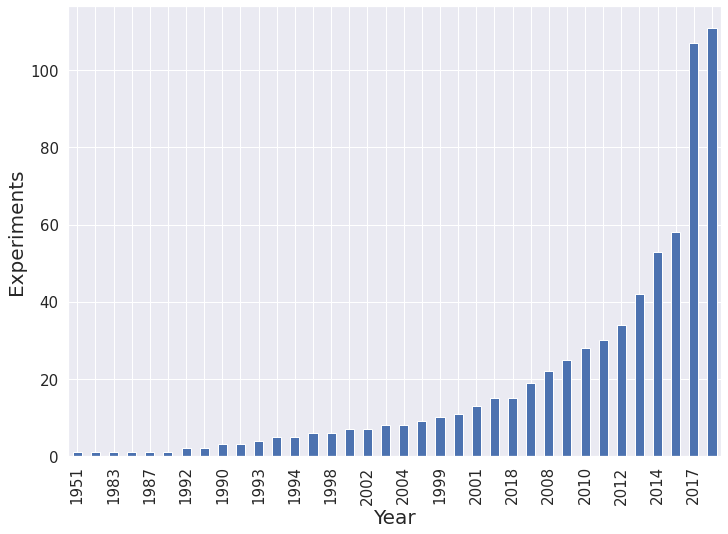

In [67]:
years = pd.read_json("/content/referenceyears.json")
years=years["year"]
ax = years.value_counts().plot.bar()
plt.gca().invert_xaxis()
plt.ylabel("Experiments", fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)
plt.setp(ax.get_xticklabels()[::2], visible=False)

Recreating species graph to match same format

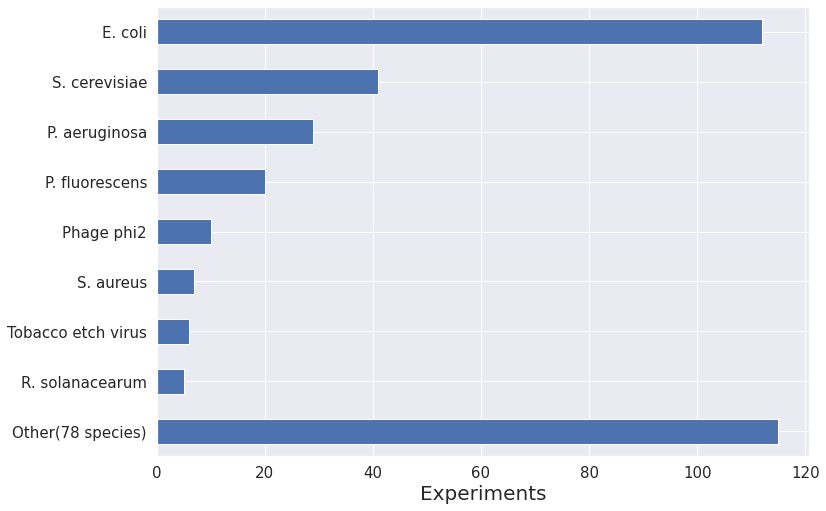

In [68]:
species = ["E. coli", "S. cerevisiae", "P. aeruginosa", "P. fluorescens", "Phage phi2", "S. aureus", "Tobacco etch virus", "R. solanacearum", "Other(78 species)"]
values = [112, 41, 29, 20, 10, 7, 6, 5, 115]

speciesdf = pd.DataFrame({'Species': species, 'Count':values})

ax = speciesdf.plot.barh(x='Species', y='Count', rot= 90, legend = False)
plt.xlabel("Experiments", fontsize = 20)
plt.ylabel("")
plt.xticks(fontsize = 15, rotation = 0)
plt.yticks(fontsize = 15, rotation = 0)
plt.gca().invert_yaxis()

Uploading new files and looking at new graphs from adapated tools. Run time took a long time so only 31 of 54 experiments were finished though this still contains all of the largest experiments and the majority of the data.

In [69]:
uploadedfinal = files.upload()

Saving 42C.csv.xlsxupdated.xlsx to 42C.csv.xlsxupdated.xlsx
Saving Auxotrophic strains hisD gltA.csv.xlsxupdated.xlsx to Auxotrophic strains hisD gltA.csv.xlsxupdated.xlsx
Saving Auxotrophic strains hisD gltB.csv.xlsxupdated.xlsx to Auxotrophic strains hisD gltB.csv.xlsxupdated.xlsx
Saving Auxotrophic strains hisD pyrC.csv.xlsxupdated.xlsx to Auxotrophic strains hisD pyrC.csv.xlsxupdated.xlsx
Saving C13.csv.xlsxupdated.xlsx to C13.csv.xlsxupdated.xlsx
Saving C321.csv.xlsxupdated.xlsx to C321.csv.xlsxupdated.xlsx
Saving C321deltaA.csv.xlsxupdated.xlsx to C321deltaA.csv.xlsxupdated.xlsx
Saving C321deltaAearlyfix.csv.xlsxupdated.xlsx to C321deltaAearlyfix.csv.xlsxupdated.xlsx
Saving Central carbon knockout glucose evolution.csv.xlsxupdated.xlsx to Central carbon knockout glucose evolution.csv.xlsxupdated.xlsx
Saving Central carbon knockout gnd.csv.xlsxupdated.xlsx to Central carbon knockout gnd.csv.xlsxupdated.xlsx
Saving Central carbon knockout pgi.csv.xlsxupdated.xlsx to Central carbon 

In [0]:
finaldf = pd.DataFrame()

In [0]:
experimentid = 1
for file in uploadedfinal.keys():
    data = pd.read_excel(file, "Sheet1").assign(ExperimentID = experimentid)
    finaldf = finaldf.append(data, ignore_index=True)
    experimentid +=1

The first thing we will look at is the distribution of cellular locations

In [78]:
finaldf

,CHROM,Start POS,End POS,TYPE,REF,ALT,GEN,∆AA,POP,CLON,TIME,FREQ,COM,Unnamed: 13,refaa,altaa,impact,score,ic,ddg,pdb_id,sequence,accession,modification_type,site_function,function_evidence,predicted_kinase,probability_loss,knockout_pvalue,tf,Interactions/Score,Total Interaction Score,Cello2go probabilities,Location,ExperimentID,index,Unnamed: 14
0,NC_000913,147727,147739.0,DEL,NaN,NaN,yadD,NaN,9,1,153,1.0,coding (760‑771/903 nt),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Extracellular,1.031,Outermembrane,0.594,Peripl...",Innermembrane,1,NaN,NaN
1,NC_000913,149214,149215.0,SNP,C,T,panB,A130T,2,1,120,1.0,A130T (GCC→ACC),NaN,A,T,1.0,0.039742,2.81168,3.87902,1M3U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"panB, 1.08",1.08,"Extracellular,1.030,Outermembrane,0.594,Peripl...",Innermembrane,1,NaN,NaN
2,NC_000913,162973,162974.0,SNP,G,A,hrpB,C290Y,6,1,135,1.0,C290Y (TGT→TAT),NaN,C,Y,1.0,0.009099,2.77868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Extracellular,1.030,Outermembrane,0.594,Peripl...",Innermembrane,1,NaN,NaN
3,NC_000913,162973,162974.0,SNP,G,A,hrpB,C290Y,8,1,131,1.0,C290Y (TGT→TAT),NaN,C,Y,1.0,0.009099,2.77868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Extracellular,1.030,Outermembrane,0.594,Peripl...",Innermembrane,1,NaN,NaN
4,NC_000913,190553,190567.0,DEL,NaN,NaN,rpsB,NaN,8,1,131,1.0,coding (680‑693/726 nt),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Extracellular,1.030,Outermembrane,0.594,Peripl...",Innermembrane,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62972,NC_000913,4600526,4600527.0,SNP,A,G,dnaC,G150G,5,3,50,1.0,G150G (GGT→GGC),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Extracellular,1.030,Outermembrane,0.594,Peripl...",Innermembrane,31,505.0,NaN
62973,NC_000913,4606330,4606331.0,INS,NaN,G,leuQ,noncoding,5,2,50,1.0,noncoding (72/87 nt),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Extracellular,2.630,Outermembrane,0.181,Peripl...",Extracellular,31,506.0,NaN
62974,NC_000913,4619018,4619019.0,SNP,A,G,deoA,T264A,5,1,50,1.0,T264A (ACG→GCG),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Extracellular,1.030,Outermembrane,0.594,Peripl...",Innermembrane,31,507.0,NaN
62975,NC_000913,4619018,4619019.0,SNP,A,G,deoA,T264A,5,2,50,1.0,T264A (ACG→GCG),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Extracellular,1.030,Outermembrane,0.594,Peripl...",Innermembrane,31,508.0,NaN


In [0]:
# finaldf["Location"].value_counts().plot.bar()
# plt.ylabel("Mutations")
# plt.xticks(rotation = 0)

Looking at impact scores of mutations

1.0    7510
0.0     233
Name: impact, dtype: int64


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

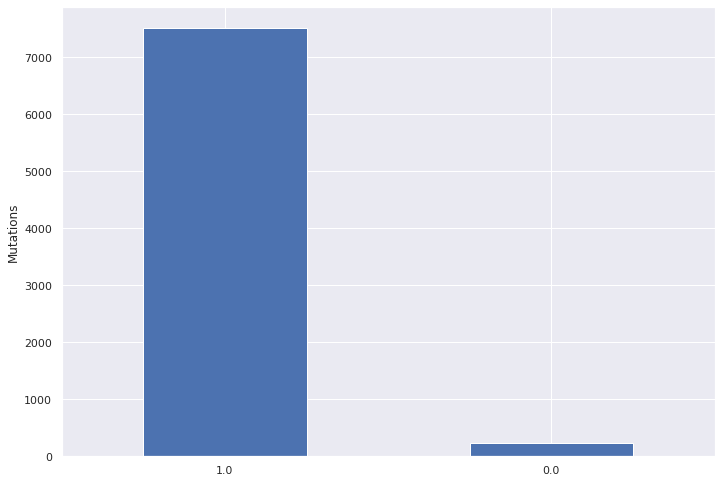

In [80]:
finaldf["impact"].value_counts().plot.bar()
print(finaldf["impact"].value_counts())
plt.ylabel("Mutations")
plt.xticks(rotation = 0)

We can also check which of the 6 categories mutations are affected by PTMs and linear motifs, Stability, Interfaces, Conservation, TFBS, and Start Stop Codons

We can also look at whether mutations affect interactions with other molecules. The higher the score the more likely these interactions are impacted.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Mechismo Score')

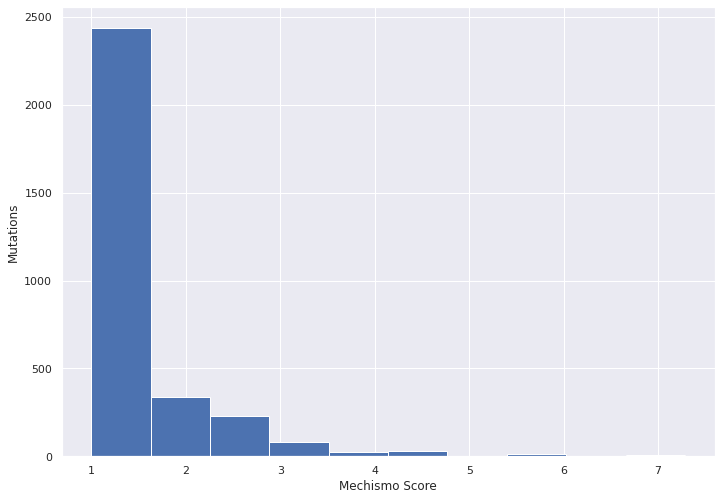

In [81]:
finaldf["Total Interaction Score"] = pd.to_numeric(finaldf["Total Interaction Score"])
plt.hist(finaldf["Total Interaction Score"])
plt.ylabel("Mutations")
plt.xlabel("Mechismo Score")
# finaldf["Total Interaction Score"].hist()